### Importing Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile as zip_
from glob import glob
from music21 import *
import pickle
import seaborn as sns
from tensorflow.keras.utils import to_categorical

%matplotlib inline

### Extracting Data

In [2]:
# Path of zip_data  and Path where data is to be extracted
working_dir = '../datasets'
zip_path = os.path.join(working_dir, 'zip_file/schubert.zip')
extraction_path = os.path.join(working_dir, 'midi_data')

# Unzipping the Data
zip = zip_.ZipFile(zip_path)
zip.extractall(extraction_path)

In [3]:
# List of extracted files
os.listdir(extraction_path)

['schubert_D850_4.mid',
 'schubert_D850_1.mid',
 'schuim-4.mid',
 'schumm-5.mid',
 'schumm-2.mid',
 'schumm-4.mid',
 'schub_d960_1.mid',
 'schubert_D935_2.mid',
 'schub_d760_1.mid',
 'schuim-2.mid',
 'schu_143_3.mid',
 'schubert_D850_3.mid',
 'schub_d960_3.mid',
 'schuim-3.mid',
 'schubert_D850_2.mid',
 'schuim-1.mid',
 'schub_d760_3.mid',
 'schu_143_2.mid',
 'schub_d760_2.mid',
 'schumm-1.mid',
 'schub_d760_4.mid',
 'schubert_D935_4.mid',
 'schu_143_1.mid',
 'schumm-6.mid',
 'schumm-3.mid',
 'schubert_D935_1.mid',
 'schubert_D935_3.mid',
 'schub_d960_2.mid',
 'schub_d960_4.mid']

### Loading and Extracting the Data

In [4]:
# Using Music21 Library for reading the midi files
# Reading a single File.

notes = []
notes_to_parse = None

file = os.path.join(extraction_path, 'schuim-4.mid')

# Parsing a Midi file
midi = converter.parse(file)   ############################      type (<class 'music21.stream.Score'>)

# Grouping based on different instruments
s2 = instrument.partitionByInstrument(midi)   #################      type (<class 'music21.stream.Score'>)

# Iterating over all Parts
for part in s2.parts:
    if "Piano" in str(part):
        # Getting all the elements to parse.
        notes_to_parse = part.recurse()      ##########    type(<class 'music21.stream.iterator.StreamIterator'>)
        
        # Finding whether the particular element is note or chord
        for element in notes_to_parse:
            
            # Getting Notes
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
                
            # Getting Chord    
            if isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
                
notes = np.array(notes)
len(notes)

3783

In [5]:
# This is the list of notes in one file
notes

array(['B5', 'G#2', 'E-6', ..., '3', '8.0.3', '8'], dtype='<U8')

In [6]:
# reading all files
def read_files(file):
    notes = []
    notes_to_parse = None

    # Parsing a Midi file
    midi = converter.parse(file)   ############################      type (<class 'music21.stream.Score'>)

    # Grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)   #################      type (<class 'music21.stream.Score'>)

    # Iterating over all Parts
    for part in s2.parts:
        if "Piano" in str(part):
            # Getting all the elements to parse.
            notes_to_parse = part.recurse()      ##########    type(<class 'music21.stream.iterator.StreamIterator'>)
        
            # Finding whether the particular element is note or chord
            for element in notes_to_parse:
            
                # Getting Notes
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                # Getting Chord    
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
                
    return np.array(notes)

In [7]:
# Loading all files and getting all their notes
midi_audio_files = glob(extraction_path + '/*.mid')
notes_ar = np.array([read_files(i) for i in midi_audio_files])

In [8]:
# Shape of notes array
notes_ar.shape

(29,)

In [9]:
# Total number of notes in first file
notes_ar[0].shape

(4243,)

In [10]:
# Storing all the notes in a single list
notes = [element for notes in notes_ar for element in notes]

In [11]:
notes = np.array(notes)
notes.shape  # Total number of notes we are having as data

(66957,)

In [12]:
# No of Unique notes in the piano data
unique_notes = list(set(notes))
len(unique_notes)

304

In [13]:
# Storing the frequency of each unique notes
frequency = dict.fromkeys(unique_notes, 0)
for i in notes:
    frequency[i] += 1

### Plotting the Frequency plot

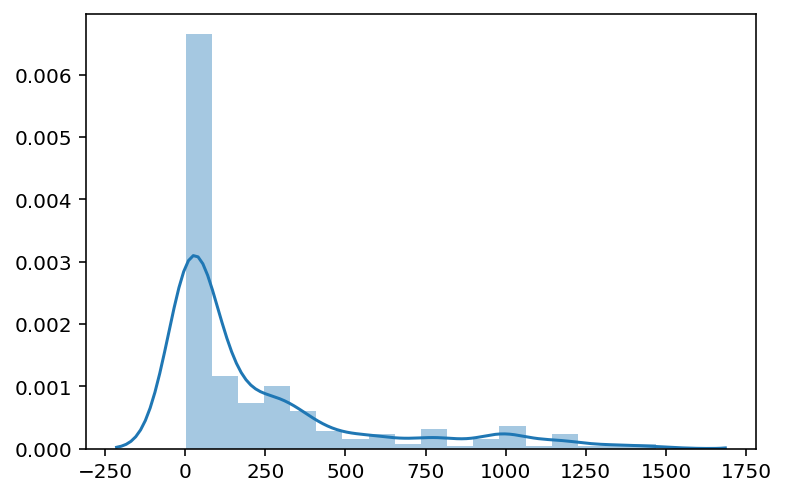

In [14]:
freq_values = list(frequency.values())
sns.distplot(freq_values, kde=True)  # Plotting the histogram with itd density distribution.

### Data Preparation

In [15]:
# Giving integer value to each notes by its pitch
pitchnames = sorted(set(item for item in notes))
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

In [16]:
# saving the pitchnames with its index
pitchnames = np.array(pitchnames)
type(pitchnames)
np.savetxt(os.path.join(os.path.join(working_dir, 'processed_data'), 'pitchnames.csv'), pitchnames, delimiter=',', fmt='%s')

In [17]:
sequence_length = 32
X_seq = []
y_seq = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length):
    X = notes[i:i + sequence_length]
    y = notes[i + sequence_length]
    X_seq.append([note_to_int[note] for note in X])
    y_seq.append(note_to_int[y])
    
# Changing each of them to numpy array
X = np.array(X)
y = np.array(y)
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [18]:
len_data = len(X_seq)

In [19]:
# Reshape the data to prevent the errors during training the model
X_seq = np.reshape(X_seq, (len_data, sequence_length, 1))

In [20]:
# Matching the output with the output patern of the lstm
y_seq = to_categorical(y_seq)

In [21]:
# Printing their shapes
X_seq.shape, y_seq.shape

((66925, 32, 1), (66925, 304))

In [22]:
# Normalize the Input
#n_vocab = len(set(notes))
#X_seq = X_seq/n_vocab

In [23]:
# Saving the data for further works
with open(os.path.join(os.path.join(working_dir, 'processed_data'), 'input.pkl'),'wb') as f:
    pickle.dump(X_seq, f)
    
with open(os.path.join(os.path.join(working_dir, 'processed_data'), 'output.pkl'),'wb') as f:
    pickle.dump(y_seq, f)

In [24]:
len(set(notes))

304

In [30]:
y_seq_ = []
for i in y_seq:
    y_seq_.append(np.argmax(i))

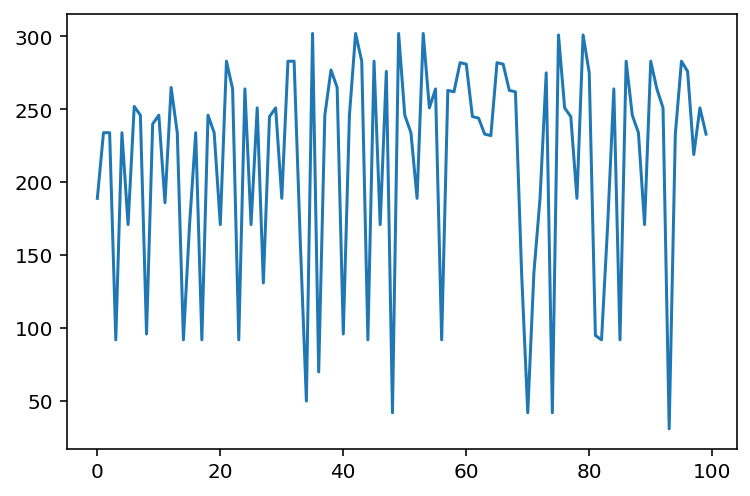

In [38]:
plt.plot(y_seq_[:100])